In [ ]:
# Import libraries
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Decompress and load the data
def load_decompressed_data(gzip_path):
    """
    Decompress and load the CSV data from a gzip file.
    """
    with gzip.open(gzip_path, 'rb') as f:
        return pd.read_csv(f)

# Paths to datasets
train_file = "../data/processed/imd_monthly_train.csv"
#test_file = "../data/processed/imd_monthly_test.csv"

# Load datasets
train_data = load_decompressed_data(train_file)
#test_data = load_decompressed_data(test_file)

# Display data overview
train_data.head()
#test_data.head()


,pos,monthID,rain_sum,rain_mean,rain_std,tmin_mean,tmin_std,tmax_mean,tmax_std
0,"(10.5, 76.5)",1,5.298247,0.170911,0.951593,17.139032,0.995635,28.302258,0.769761
1,"(10.5, 77.5)",1,30.434262,0.981750,3.753896,17.600968,0.961833,28.270968,1.129780
2,"(10.5, 78.5)",1,34.014397,1.097239,3.222228,20.922581,0.974286,30.406452,1.234962
3,"(10.5, 79.5)",1,284.678233,9.183169,22.217352,21.787419,0.980483,29.621613,1.035568
4,"(11.5, 75.5)",1,19.827823,0.639607,2.764289,18.292903,1.010855,29.275161,0.657165


In [3]:
# Check the data types of the columns
print(train_data.dtypes)

# Identify non-numeric columns
non_numeric_cols = train_data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)


pos           object
monthID        int64
rain_sum     float64
rain_mean    float64
rain_std     float64
tmin_mean    float64
tmin_std     float64
tmax_mean    float64
tmax_std     float64
dtype: object
Non-numeric columns: Index(['pos'], dtype='object')


In [4]:
# column containing longitude and latitude as strings
position_col = "pos"

# Extract latitude and longitude as separate columns
train_data[['latitude', 'longitude']] = train_data[position_col].str.extract(r'\(([\d.-]+),\s*([\d.-]+)\)').astype(float)
#test_data[['latitude', 'longitude']] = test_data[position_col].str.extract(r'\(([\d.-]+),\s*([\d.-]+)\)').astype(float)

# Drop the original column
train_data.drop(columns=[position_col], inplace=True)
#test_data.drop(columns=[position_col], inplace=True)


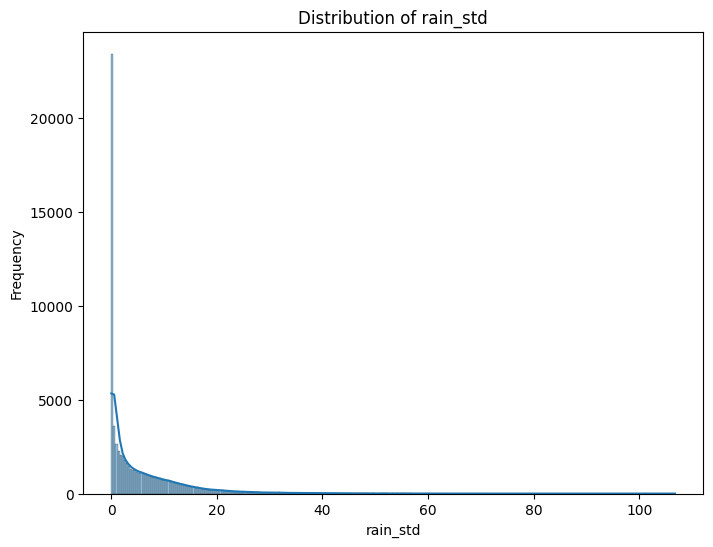

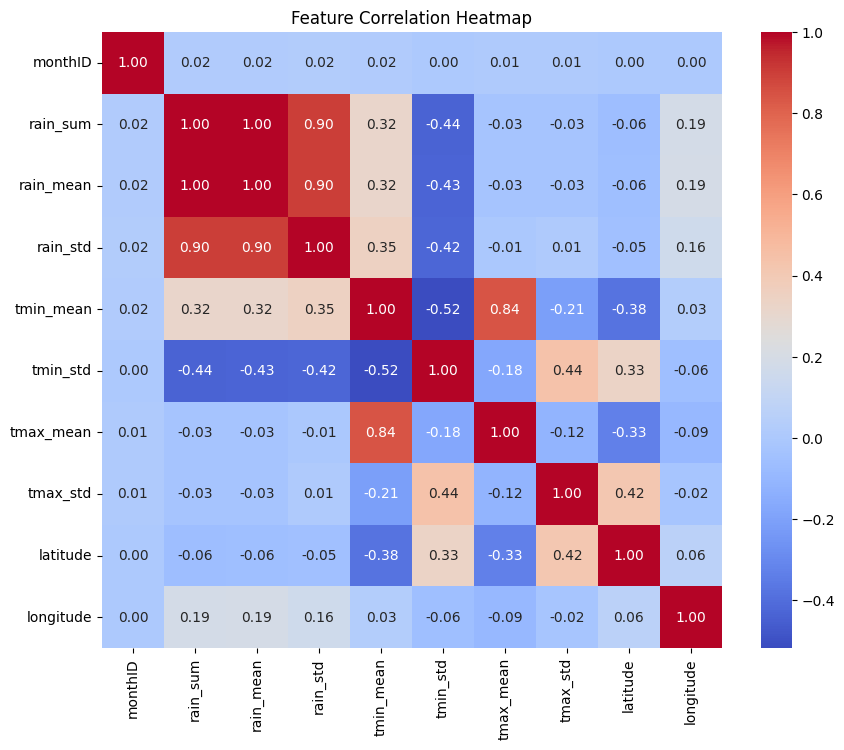

In [5]:
def visualize_data(data, target_col):
    """
    Visualize the distribution of the target column and feature correlations.
    """
    # Distribution of the target column
    plt.figure(figsize=(8, 6))
    sns.histplot(data[target_col], kde=True)
    plt.title(f"Distribution of {target_col}")
    plt.xlabel(target_col)
    plt.ylabel("Frequency")
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Feature Correlation Heatmap")
    plt.show()

visualize_data(train_data, target_col="rain_std")


In [6]:
def clean_and_normalize(data, target_col):
    """
    Clean the dataset by handling missing values and normalize features.
    """
    # Handle missing values using forward-fill and backward-fill
    data = data.fillna(method="ffill").fillna(method="bfill")

    # Normalize numerical features (except the target column)
    scaler = MinMaxScaler()
    features = data.columns.difference([target_col])
    data[features] = scaler.fit_transform(data[features])

    return data

# Clean and normalize datasets
train_data = clean_and_normalize(train_data, target_col="rain_mean")
#test_data = clean_and_normalize(test_data, target_col="rain_mean")

# Verify the transformation
train_data.head()

/var/folders/d1/7wxbrt_n08751tpz72gkwf4m0000gn/T/ipykernel_15310/3942535218.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")


,monthID,rain_sum,rain_mean,rain_std,tmin_mean,tmin_std,tmax_mean,tmax_std,latitude,longitude
0,0.0,0.001634,0.170911,0.008912,0.614976,0.201250,0.570147,0.093813,0.074074,0.285714
1,0.0,0.009387,0.981750,0.035156,0.628729,0.193074,0.569295,0.158747,0.074074,0.321429
2,0.0,0.010491,1.097239,0.030177,0.727624,0.196086,0.627421,0.177718,0.074074,0.357143
3,0.0,0.087807,9.183169,0.208068,0.753373,0.197585,0.606058,0.141755,0.074074,0.392857
4,0.0,0.006116,0.639607,0.025888,0.649330,0.204931,0.596628,0.073505,0.111111,0.250000


In [7]:
# Step 1: Identify unique locations
unique_locations = train_data[["latitude", "longitude"]].drop_duplicates()

# Step 2: Select 5 random locations
selected_locations = unique_locations.sample(5, random_state=42)

# Step 3: Filter the data for selected locations
train_data_filtered = train_data.merge(selected_locations, on=["latitude", "longitude"], how="inner")
#test_data_filtered = test_data.merge(selected_locations, on=["latitude", "longitude"], how="inner")

def create_sequences(data, features, target_col, time_steps=30):

    X, y = [], []
    for i in range(len(data) - time_steps):
        # Extract a sequence of selected features for the past 'time_steps'
        X.append(data.iloc[i:i+time_steps][features].values)

        # Extract the target value at the time step following the sequence
        y.append(data.iloc[i+time_steps][target_col])

    return np.array(X), np.array(y)

# Define the columns for features and target
feature_columns = ["monthID", "tmin_mean", "tmax_mean", "latitude", "longitude"]
target_column = "rain_mean"

# Define time steps
time_steps = 30

# Create sequences for training and test datasets
X_train, y_train = create_sequences(train_data, features=feature_columns, target_col=target_column, time_steps=time_steps)
#X_test, y_test = create_sequences(test_data, features=feature_columns, target_col=target_column, time_steps=time_steps)

# Check the shape of the sequences
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
#print("X_test shape:", X_test.shape)
#print("y_test shape:", y_test.shape)

X_train shape: (71946, 30, 5)
y_train shape: (71946,)


/Users/praveenp/Documents/Projects/Project_01/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-21 23:09:53.584310: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-11-21 23:09:53.584352: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-21 23:09:53.584366: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-21 23:09:53.584405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 23:09:53.584415: I tensorflow/core/common_runtime/pluggable_device/pl

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 14, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,275 (172.95 KB)

 Trainable params: 44,275 (172.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2024-11-21 23:09:54.689006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1799/1799 ━━━━━━━━━━━━━━━━━━━━ 506s 280ms/step - loss: 21.8144 - mse: 21.8144 - val_loss: 18.4615 - val_mse: 18.4615
Epoch 2/20
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 566s 315ms/step - loss: 16.7513 - mse: 16.7513 - val_loss: 16.2115 - val_mse: 16.2115
Epoch 3/20
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 542s 301ms/step - loss: 16.7106 - mse: 16.7106 - val_loss: 15.4867 - val_mse: 15.4867
Epoch 4/20
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 1678s 933ms/step - loss: 16.2554 - mse: 16.2554 - val_loss: 15.9953 - val_mse: 15.9953
Epoch 5/20
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 493s 274ms/step - loss: 15.5911 - mse: 15.5911 - val_loss: 14.0658 - val_mse: 14.0658
Epoch 6/20
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 495s 275ms/step - loss: 14.4316 - mse: 14.4316 - val_loss: 13.0429 - val_mse: 13.0429
Epoch 7/20
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 494s 275ms/step - loss: 13.6965 - mse: 13.6965 - val_loss: 13.3576 - val_mse: 13.3576
Epoch 8/20
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 494s 275ms/step - loss: 13.2955 - mse: 13.2955 - val_loss: 16.5563 - val

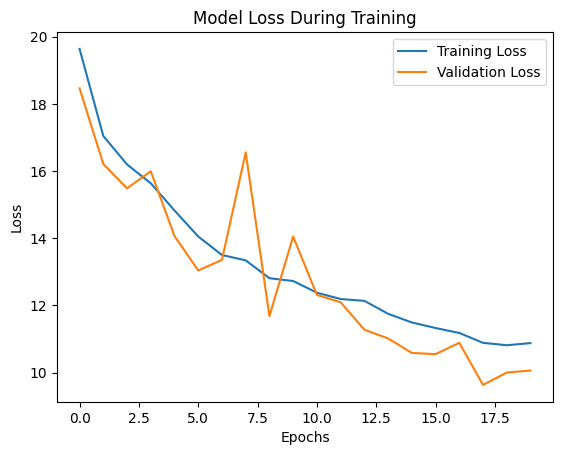

In [8]:
# Build the CNN-LSTM model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(time_steps, X_train.shape[2])))

# Add a max-pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.3))

# Add LSTM layers
model.add(LSTM(50, activation="relu", return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50, activation="relu"))

# Add a dense output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mse"])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Plot the training history
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Model Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [9]:
# Save the trained model
model.save('../models/CNN_LSTM_Monthly_Model.keras')